In [1]:
import sys
sys.path.append('../../../')

import numpy as np
import pandas as pd
import torch as tc

from scipy.linalg import lapack

import time
from tqdm import tqdm

#Plotting
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Ellipse


FILE_PATH = "../../../data/DJI.txt"

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

from rcgp.weight_functions import IMQ, partial_y_IMQ
from rcgp.experimental import SpatioTemporalRCGP
from rcgp.rcgp import TemporalRCGP

In [2]:
def get_data(n_days=2):
    crash_date = pd.Timestamp('2013-04-23')
    DJI = pd.read_csv(FILE_PATH, header = None)
    DJI.columns =['date', 'open', 'high', 'low', 'close']
    DJI['date'] = pd.to_datetime(DJI['date'])

    crash_date = pd.Timestamp('2013-04-23')
    dates = list(pd.date_range(end=crash_date, periods=n_days, freq='B').astype(str))
    flash_crash_dji = DJI[DJI.date.dt.date.astype(str).isin(dates)]

    obs_grid = np.linspace(0, 1, len(flash_crash_dji)).reshape(-1,1)
    obs = flash_crash_dji["close"].to_numpy()
    obs_center = obs.mean()
    obs_std = obs.std()
    obs = (obs - obs_center)/obs_std

    return flash_crash_dji, obs_grid, obs, obs_center, obs_std

In [3]:
flash_crash_dji, obs_grid, obs, obs_center, obs_std = get_data(n_days=2)

In [4]:
def gp_sklearn(alpha, obs_grid, obs):

    gpr = GaussianProcessRegressor(kernel= 1.0 * Matern(), alpha=alpha)
    gpr.fit(obs_grid, obs)
    mu_sklearn, std_sklearn = gpr.predict(obs_grid, return_std=True)

    print("kernel parameters:")
    print(gpr.kernel_.get_params())

    return gpr, mu_sklearn, std_sklearn

def gp_sklearn_predict(alpha, obs_grid, obs):
    kernel = 0.72 * Matern(length_scale=0.0955, nu=1.5, length_scale_bounds='fixed')
    gpr = GaussianProcessRegressor(kernel= kernel, alpha=alpha, optimizer=None); #note that we're not optimizing here
    gpr.fit(obs_grid, obs);
    mu_sklearn, std_sklearn = gpr.predict(obs_grid, return_std=True);

    return mu_sklearn, std_sklearn


#Run Sklearn
model_sklearn, mu_sklearn, std_sklearn = gp_sklearn(alpha=0.02, obs_grid=obs_grid, obs=obs)

kernel parameters:
{'k1': 0.849**2, 'k2': Matern(length_scale=0.0955, nu=1.5), 'k1__constant_value': 0.7210007500681667, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': 0.09553133897502876, 'k2__length_scale_bounds': (1e-05, 100000.0), 'k2__nu': 1.5}


In [5]:
inds_cache = {}

def upper_triangular_to_symmetric(ut):
    n = ut.shape[0]
    try:
        inds = inds_cache[n]
    except KeyError:
        inds = np.tri(n, k=-1, dtype=bool)
        inds_cache[n] = inds
    ut[inds] = ut.T[inds]


def inv(m):
    cholesky, info = lapack.dpotrf(m)
    if info != 0:
        raise ValueError('dpotrf failed on input {}'.format(m))
    inv, info = lapack.dpotri(cholesky)
    if info != 0:
        raise ValueError('dpotri failed on input {}'.format(cholesky))
    upper_triangular_to_symmetric(inv)
    return inv


def rcgp(scale, obs_grid, obs, return_std=True):
    magnitude = 1.
    lengthscale = 0.09
    nu = 1 + 1/2
    matern_kernel = magnitude * Matern(length_scale=lengthscale, nu=nu)

    #m = ((obs[-1] - obs[0])/(obs_grid[-1] - obs_grid[0]) * obs_grid).flatten()
    m = np.zeros_like(obs_grid, dtype=np.float32).flatten() + obs.mean()

    beta= 1.
    c= 0.25


    K = matern_kernel(obs_grid.reshape(-1,1))
    

    w = IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float32)
    partial_w = partial_y_IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float64)

    J_w = np.diag((scale**2 / 2) * w**(-2))

    m_w = m + 2 * scale**2 * (w)**(-1) * partial_w

    A = inv(K + scale**2 * J_w)

    mu_rcgp = m + K @ A @ (obs - m_w)

    if return_std:
        Sigma = K @ A @ (scale**2 * J_w)
        std_rcgp = np.sqrt(np.diag(Sigma))
    
        return mu_rcgp.flatten(), std_rcgp

    else:
        return mu_rcgp.flatten()
    
def rcgp_predict(scale, obs_grid, obs):
    magnitude = 1.
    lengthscale = 0.09
    nu = 1 + 1/2
    matern_kernel = magnitude * Matern(length_scale=lengthscale, nu=nu)

    #m = ((obs[-1] - obs[0])/(obs_grid[-1] - obs_grid[0]) * obs_grid).flatten()
    m = np.zeros_like(obs_grid, dtype=np.float32).flatten() + obs.mean()

    beta= 1.
    c= 0.25


    K = matern_kernel(obs_grid.reshape(-1,1))
    

    w = IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float32)
    partial_w = partial_y_IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float64)

    J_w = np.diag((scale**2 / 2) * w**(-2))

    m_w = m + 2 * scale**2 * (w)**(-1) * partial_w

    A = inv(K + scale**2 * J_w)

    return m + K @ A @ (obs - m_w)


mu_rcgp, std_rcgp = rcgp(0.2, obs_grid, obs)

In [6]:
def get_rtgp(obs_grid, obs):
    with tc.no_grad():
        #rtgp = SpatioTemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), grid=None, Ys=tc.from_numpy(obs).reshape(-1,1), p=2)
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=2)
        rtgp.activate_robustness(func="m_pred")

        rtgp.temporal_lengthscale = 0.1
        rtgp.temporal_magnitude = 1. 

        rtgp.beta = 1.
        rtgp.adaptive_c()
        #rtgp.c = 0.5


        rtgp.var_y = 0.02
        (preds_smooth, stds_smooth, eff), _, _ = rtgp.forward()
        
        return preds_smooth, stds_smooth, eff, rtgp

mu_rtgp, std_rtgp, eff, rtgp_model = get_rtgp(obs_grid=obs_grid, obs=obs)

In [7]:
def get_comp_time(n_max):
    n_vals = np.arange(1, n_max+1)
    rtgp_times = []
    rcgp_times = []
    gp_times = []
    dataset_size = []


    for n in tqdm(n_vals):
        flash_crash_dji, obs_grid, obs, obs_center, obs_std = get_data(n_days=n)

        t1 = time.time()
        _=get_rtgp(obs_grid=obs_grid, obs=obs)
        t2 = time.time()

        rtgp_times.append(t2 - t1)
        
        t1 = time.time()
        _=rcgp_predict(scale=0.2, obs_grid=obs_grid, obs=obs)
        t2 = time.time()
        rcgp_times.append(t2 - t1)

        t1 = time.time()
        _=gp_sklearn_predict(alpha=0.02, obs_grid=obs_grid, obs=obs)
        t2 = time.time()
        gp_times.append(t2 - t1)

        dataset_size.append(len(obs))

    df = pd.DataFrame(np.vstack([rtgp_times, rcgp_times, gp_times, dataset_size]), columns=n_vals, index=['rtgp', 'rcgp', 'gp', 'size'])
    
    return df.T

def avg_comp_time(n_max):
    df = get_comp_time(n_max)

    for i in range(4):
        df+= get_comp_time(n_max)

    return df * (1/5)


#df = get_comp_time(30) #Only run if needed. Results are stored in "runtime.csv"
"""df.to_csv(COMP_TIME_OUTPUT_FILE)
"""

'df.to_csv(COMP_TIME_OUTPUT_FILE)\n'

In [8]:
#Number of Data Points
len(flash_crash_dji)

810

In [9]:
rp_mean = np.loadtxt("relevance_pursuit_mean.txt")
rp_dates = pd.to_datetime(np.loadtxt("relevant_pursuit_dates.txt"))

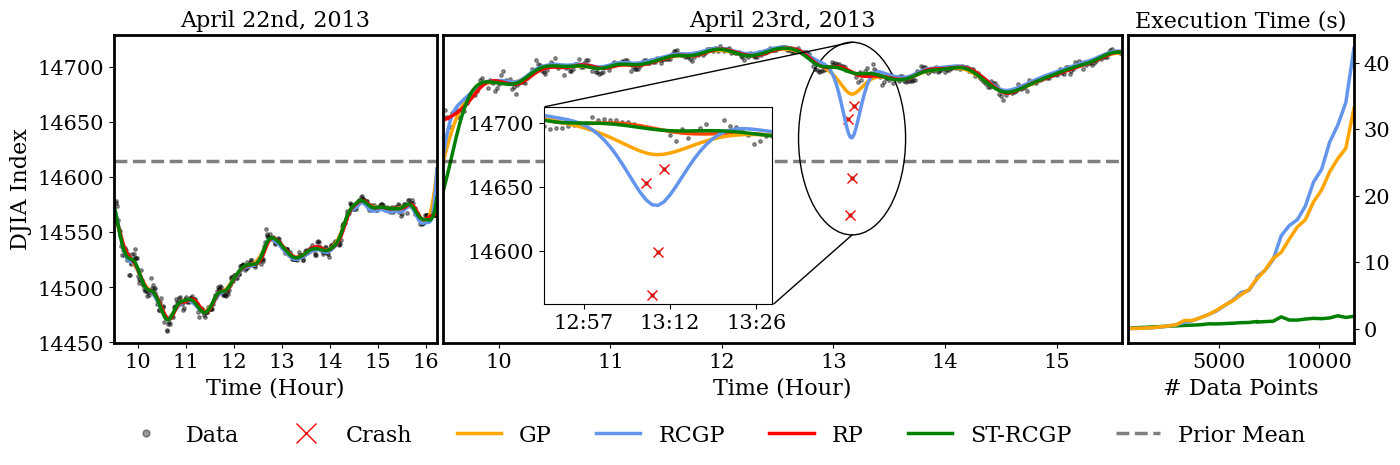

In [10]:
plt.rc('font', family='serif', size=15)
#plt.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 2.5

fig, axs = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'width_ratios': [1, 2.1, 0.7]})

dates = pd.to_datetime(flash_crash_dji.date)

idx0 = dates < '2013-04-23'
idx1 = (dates >= '2013-04-23') & (dates <= dates.iloc[-40])

idx0_rp = rp_dates < '2013-04-23'
idx1_rp = (rp_dates >= '2013-04-23') & (rp_dates <= dates.iloc[-40])

x0 = dates[idx0]
x1 = dates[idx1]

df = pd.read_csv("./comp-time-djia-crash.csv")

pred_rtgp = mu_rtgp.flatten().numpy()

axs[0].plot(x0, obs[idx0]* obs_std + obs_center, '.', markersize=5, color='black', alpha=0.4, label='Data')
axs[1].plot(x1, obs[idx1]* obs_std + obs_center, '.', markersize=5, color='black', alpha=0.4, label='Data')

outlier_min_idx = obs[idx1].argmin() - 1
outlier_max_idx = obs[idx1].argmin() + 3
axs[1].plot(x1.iloc[outlier_min_idx: outlier_max_idx], obs[idx1][outlier_min_idx: outlier_max_idx]* obs_std + obs_center, 'x', markersize=7, color='red', alpha=1, label='Crash')
axs[0].set_xlim(x0.iloc[0], x0.iloc[-1])
axs[1].set_xlim(x1.iloc[0], x1.iloc[-1])

axs[0].plot(x0, mu_sklearn[idx0] * obs_std + obs_center, color='orange', label="GP")
axs[1].plot(x1, mu_sklearn[idx1]* obs_std + obs_center, color='orange', label="GP")

axs[0].plot(x0, mu_rcgp[idx0]* obs_std + obs_center, color='cornflowerblue', label="RCGP")
axs[1].plot(x1, mu_rcgp[idx1]* obs_std + obs_center, color='cornflowerblue', label="RCGP")

axs[0].plot(rp_dates[idx0_rp], rp_mean[idx0_rp], color='red', label='RP')
axs[1].plot(rp_dates[idx1_rp], rp_mean[idx1_rp], color='red', label='RP')

axs[0].plot(x0, pred_rtgp[idx0]* obs_std + obs_center, color='green', label="ST-RCGP")
axs[1].plot(x1, pred_rtgp[idx1]* obs_std + obs_center, color='green', label="ST-RCGP")




axs[0].plot(x0, np.zeros(len(x0.index)).flatten() + obs.mean()* obs_std + obs_center,'--', color='black', alpha=0.5, label='Prior Mean')
axs[1].plot(x1, np.zeros(len(x1.index)).flatten() + obs.mean()* obs_std + obs_center,'--', color='black', alpha=0.5, label='Prior Mean')

fontweight = 'normal'
axs[0].set_ylabel("DJIA Index", fontweight = fontweight, fontsize=16)
#axs[0,0].legend(loc='upper left', ncol=2)
axs[1].tick_params(left=False)
axs[0].set_title('April 22nd, 2013', fontweight = fontweight, fontsize=16)
axs[1].set_title('April 23rd, 2013', fontweight = fontweight, fontsize=16)

axs[0].set_xlabel("Time (Hour)", fontsize=16)
axs[1].set_xlabel("Time (Hour)", fontsize=16)

ymin = min(obs* obs_std + obs_center) - 10
ymax = max(obs* obs_std + obs_center) + 10


axs[1].get_yaxis().set_visible(False)
axs[1].set_ylim(ymin, ymax)
axs[0].set_ylim(ymin, ymax)


axs[2].plot(df["size"].astype(int), df["rtgp"], color='green', label="ST-RCGP")
axs[2].plot(df["size"].astype(int), df["rcgp"], color='cornflowerblue', label="RCGP")
axs[2].plot(df["size"].astype(int), df["gp"], color='orange', label="GP")

axs[2].set_xlabel("# Data Points", fontweight=fontweight, fontsize=16)
axs[2].set_title("Execution Time (s)", fontweight=fontweight, fontsize=16)

axs[2].set_xlim(df['size'].min(), df['size'].max())
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")

plt.subplots_adjust(wspace=0.015, hspace=0.3)

for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set border thickness
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set border thickness

axs[1].legend(bbox_to_anchor=(1.3,-0.2), fontsize=16, labelspacing = 1, frameon=False, shadow=True, markerscale=2, ncol=7)

for i in range(2): 
    axs[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H'))
    #axs[i].xaxis.set_tick_params(rotation=20)
    #axs[i].xaxis.set_major_locator(plt.MaxNLocator(6))

idx_zoom_in = (dates > '2013-04-23 12:50') & (dates < '2013-04-23 13:30')
idx_zoom_in_rp = (rp_dates > '2013-04-23 12:50') & (rp_dates < '2013-04-23 13:30')

x_zoom = x1[idx_zoom_in]
obs_zoom = obs[idx_zoom_in]

inset_ax = inset_axes(axs[1], width="24%", height="32%", bbox_to_anchor=(-0.9, -1.2, 1.4, 2.), bbox_transform=axs[1].transAxes)  # Size and position

inset_ax.plot(x_zoom, obs_zoom * obs_std + obs_center, '.', markersize=5, color='black', alpha=0.4)  # Plot the same data on the inset
inset_ax.plot(x_zoom.iloc[17:21], obs_zoom[17:21] * obs_std + obs_center, 'x', markersize=7, color='red')
inset_ax.plot(rp_dates[idx_zoom_in_rp], rp_mean[idx_zoom_in_rp], color='orangered')
inset_ax.plot(x_zoom, mu_sklearn[idx_zoom_in] * obs_std + obs_center, color='orange')
inset_ax.plot(x_zoom, mu_rcgp[idx_zoom_in]* obs_std + obs_center, color='cornflowerblue')
inset_ax.plot(x_zoom, pred_rtgp[idx_zoom_in]* obs_std + obs_center, color='green')

inset_ax.set_xlim(x_zoom.iloc[0], x_zoom.iloc[-1])


inset_ax.xaxis.set_major_locator(plt.MaxNLocator(3))
inset_ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))


ellipse = Ellipse(
    (x1.iloc[220], 14635),  # (x, y) center of the ellipse
    width=0.04,  # Total width of the ellipse
    height=175,  # Total height of the ellipse
    edgecolor="black",
    facecolor="none",
    linewidth=1.,
)
axs[1].add_patch(ellipse)

axs[1].plot([x1.iloc[220], x1.iloc[55]], [ 14635 + 175/2, 14664], color="black", linewidth=1.)
axs[1].plot([x1.iloc[220], x1.iloc[178]], [ 14635 - 175/2, 14485], color="black", linewidth=1.)


#plt.savefig("./RCGP-vs-STRCGP-djia-crash-with-exec-time-long.pdf", format='pdf', bbox_inches='tight')